This notebook serves as a control panel for support simulations of network activity propagating along a ridge of CA3 PCs receiving EC input through potentiated EC->PC synapses, specifically in the case in which the ridge is embedded within a larger, non-potentiated CA3 network, i.e. mimicking the idea that it was temporarily "raised" by place-tuned inputs as the rat followed a trajectory through a 2D environment.

In [1]:
import aux

from search import embedded
from search import embedded_pre
from search import embedded_global as C

import PARAMETERS as P

### Preliminary computation of w_n_pc_ec, v_0, and g_n_0 distributions

In [ ]:
# pre-compute w_n_ec_pc vs. dist distributions 
embedded_pre.w_n_pc_ec_vs_dist(C, P);

In [ ]:
# pre-compute v/g_n vs. w_n_pc_ec and fr_ec distributions
embedded_pre.v_g_n_vs_w_n_pc_ec_fr_ec(C, P);

### Objective function instantiation

In [2]:
# load pre-computed files
pre = {
    'w_n_pc_ec_vs_dist': aux.load(C.PATH_W_N_PC_EC_VS_DIST),
    'v_g_n_vs_w_n_pc_ec_fr_ec': aux.load(C.PATH_V_G_N_VS_W_N_PC_EC_FR_EC)
}

# define objective function
def obj(p, seed):
    
    return embedded.ntwk_obj(p, pre, C, P, seed)

# Searcher control panel

In [ ]:
embedded.search('smln_0_random', obj, C)

# Tests

In [1]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

from plot import set_font_size

### Unit tests of pre-computation functions

In [2]:
from search import embedded_pre

import PARAMETERS as P

class EmbeddedGlobal(object):
    """Mock global config file."""
    
    SEED_PRE = 0
    
    ## W_N_PC_EC VS DIST COMPUTATION
    
    PATH_W_N_PC_EC_VS_DIST = 'search/pre/embedded/test_w_n_ec_pc_vs_dist.npy'

    DUR_W_PRE = 5
    STIM_W_PRE = (0, 2)
    N_TRIALS_W_PRE = 10
    DIST_PRE = np.linspace(0, 0.3, 25)

    ## V, G_N VS W_N_PC_EC, FR_EC COMPUTATION

    PATH_V_G_N_VS_W_N_PC_EC_FR_EC = 'search/pre/embedded/test_v_g_n_vs_w_n_pc_ec_fr_ec.npy'

    DUR_V_G_PRE = 6
    MEASURE_START_V_G_PRE = 1
    N_TIMEPOINTS_V_G_PRE = 1000

    W_N_PC_EC_PRE = np.linspace(0, 0.002, 50)
    FR_EC_PRE = np.linspace(20, 70, 20)
    
C = EmbeddedGlobal()

##### Pre-computation of w_n_ec_pc vs dist
Show plot and check that file was saved correctly, then delete file.

w_n_pc_ec vs dists file saved at "search/pre/embedded/test_w_n_ec_pc_vs_dist.npy".


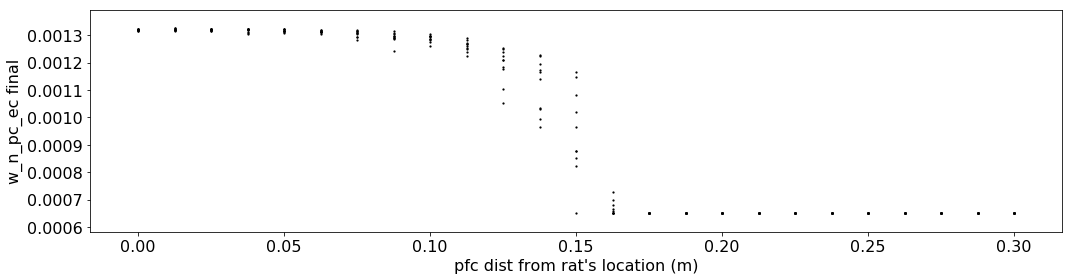

In [3]:
embedded_pre.w_n_pc_ec_vs_dist(C, P)
assert os.path.isfile(C.PATH_W_N_PC_EC_VS_DIST)
os.remove(C.PATH_W_N_PC_EC_VS_DIST)

Test passed if plot shows reverse-sigmoid-like function.

v, g_n vs w_n_pc_ec, fr_ec saved at "search/pre/embedded/test_v_g_n_vs_w_n_pc_ec_fr_ec.npy".


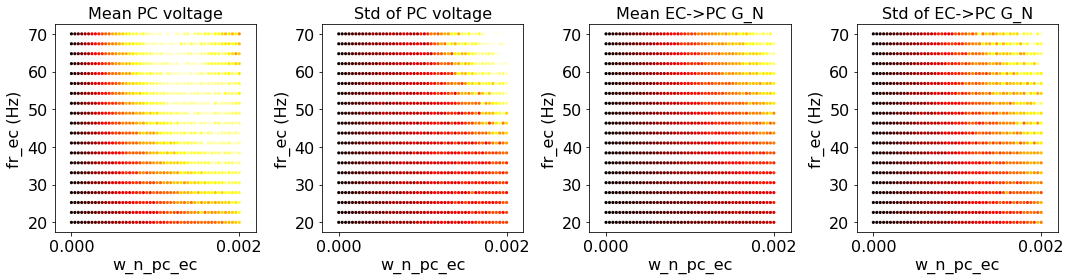

In [4]:
embedded_pre.v_g_n_vs_w_n_pc_ec_fr_ec(C, P)
assert os.path.isfile(C.PATH_V_G_N_VS_W_N_PC_EC_FR_EC)
os.remove(C.PATH_V_G_N_VS_W_N_PC_EC_FR_EC)

Test passed if mean voltage and EC->PC G_N appear to increase to the upper left.

### Unit tests of ntwk/ridge creation

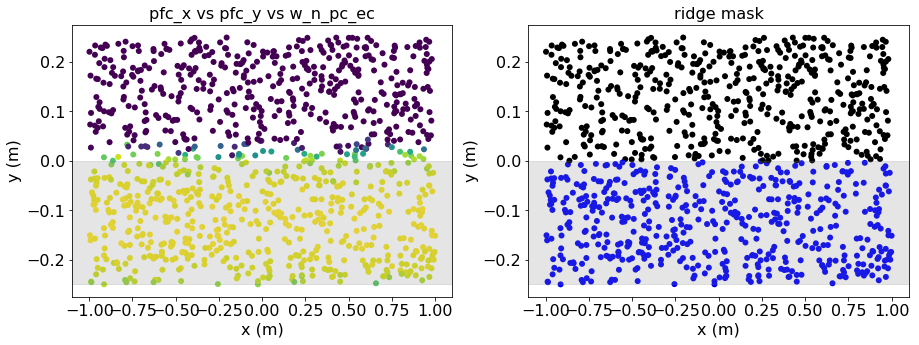

In [5]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import aux
from plot import set_font_size
from search.embedded import embedded_hz, get_ridge_mask

import search.embedded_global as C


class Ntwk(object):    
    pass

np.random.seed(0)

# load pre-computed files
pre = {
    'w_n_pc_ec_vs_dist': aux.load(C.PATH_W_N_PC_EC_VS_DIST),
    'v_g_n_vs_w_n_pc_ec_fr_ec': aux.load(C.PATH_V_G_N_VS_W_N_PC_EC_FR_EC)
}

# make ridge
p = {'AREA_H': 0.5, 'AREA_W': 2, 'RIDGE_Y': -0.125, 'RHO_PC': 1000}
pfcs, ws_n_pc_ec = embedded_hz(p, pre)

# get ridge mask
C.RIDGE_H = 0.25
ntwk = Ntwk()
ntwk.cell_types = np.repeat('PC', pfcs.shape[1])
ntwk.pfcs = pfcs

ridge_mask = get_ridge_mask(ntwk, p, C)

# plot area/ridge colored by (1) w_n_pc_ec, and (2) ridge_mask
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# (1)
axs[0].scatter(
    pfcs[0], pfcs[1], c=ws_n_pc_ec, lw=0, zorder=0,
    vmin=ws_n_pc_ec.min(), vmax=ws_n_pc_ec.max())
axs[0].axhspan(p['RIDGE_Y'] - C.RIDGE_H/2, p['RIDGE_Y'] + C.RIDGE_H/2, color='gray', alpha=0.2)
axs[0].set_xlim(-.55*p['AREA_W'], .55*p['AREA_W'])
axs[0].set_ylim(-.55*p['AREA_H'], .55*p['AREA_H'])

axs[0].set_xlabel('x (m)')
axs[0].set_ylabel('y (m)')
axs[0].set_title('pfc_x vs pfc_y vs w_n_pc_ec')

# (2)
c = np.repeat('k', pfcs.shape[1])
c[ridge_mask] = 'b'

axs[1].scatter(pfcs[0], pfcs[1], c=c, lw=0)
axs[1].axhspan(p['RIDGE_Y'] - C.RIDGE_H/2, p['RIDGE_Y'] + C.RIDGE_H/2, color='gray', alpha=0.2)
axs[1].set_xlim(-.55*p['AREA_W'], .55*p['AREA_W'])
axs[1].set_ylim(-.55*p['AREA_H'], .55*p['AREA_H'])

axs[1].set_xlabel('x (m)')
axs[1].set_ylabel('y (m)')
axs[1].set_title('ridge mask')

for ax in axs:
    set_font_size(ax, 16)

Tests passed if gray rectangle covers yellow cells in left panel and blue cells in right panel.

### Unit test of angle computation and trajectory decoding

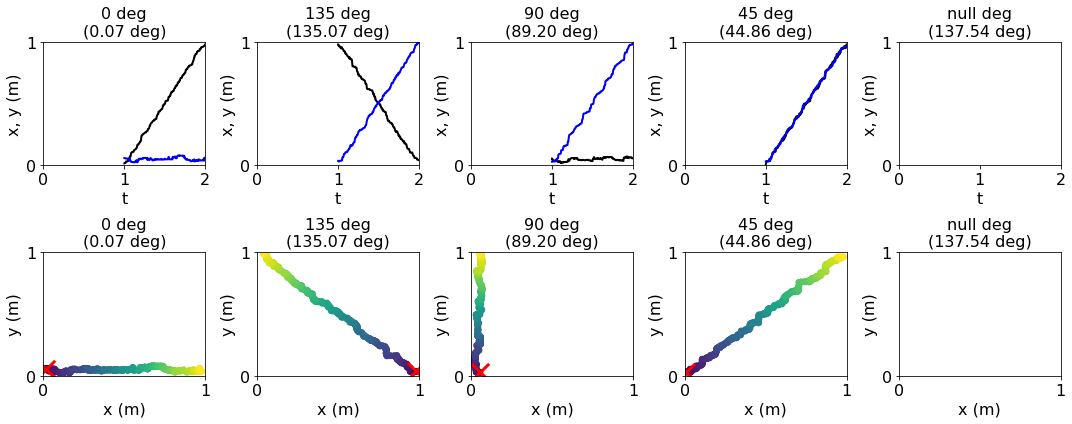

In [6]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from plot import set_font_size
from search.embedded import get_angle, decode_traj


class Rsp():
    pass


np.random.seed(0)

pfcs = np.random.uniform(0, 1, (2, 2000))
n = pfcs.shape[1]

t_ = np.arange(0, 1, .001)

t = np.tile(t_[:, None], (1, n))
x = np.tile(pfcs[[0], :], (len(t_), 1))
y = np.tile(pfcs[[1], :], (len(t_), 1))

spks = {
    0: (x >= t - 0.05) & (x < t + 0.05) & (y < 0.1),
    135: (x >= 1 - t - 0.05) & (x < 1 - t + 0.05) & (y >= t - 0.05) & (y < t + 0.05),
    90: (x < 0.1) & (y >= t - 0.05) & (y < t + 0.05),
    45: (x >= t - 0.05) & (x < t + 0.05) & (y >= t - 0.05) & (y < t + 0.05),
    'null': np.random.rand(*t.shape) > 0.9
}

# make sure angles are correctly computed
rsps = {}
wdw = (1, 2)
angles = {}

for angle_correct, spks_ in spks.items():
    rsp = Rsp()
    
    rsp.cell_types = np.repeat('PC', n)
    rsp.pfcs = pfcs
    rsp.ts = np.concatenate([t_, t_ + 1])
    rsp.spks = np.concatenate([np.zeros(t.shape), spks_], axis=0)
    
    angle = get_angle(rsp, wdw)
    
    if angle_correct != 'null':
        assert np.abs(angle - angle_correct) < 10

    angles[angle_correct] = angle
    
    rsps[angle_correct] = rsp
    

# plot decoded trajectories
fig, axs = plt.subplots(2, 5, figsize=(15, 6), tight_layout=True)

for ctr, (angle_correct, rsp) in enumerate(rsps.items()):
    ts, xs, ys = decode_traj(rsp, wdw, smooth=0.003, mad_max=0.1)
    
    axs[0, ctr].plot(ts, xs, color='k', lw=2)
    axs[0, ctr].plot(ts, ys, color='b', lw=2)
    
    axs[0, ctr].set_xlim(0, 2)
    axs[0, ctr].set_ylim(0, 1)
    
    axs[0, ctr].set_xticks([0, 1, 2])
    axs[0, ctr].set_yticks([0, 1])
    
    axs[0, ctr].set_xlabel('t')
    axs[0, ctr].set_ylabel('x, y (m)')
    
    axs[1, ctr].scatter(xs, ys, c=np.arange(len(xs)), zorder=0)
    axs[1, ctr].scatter(xs[0], ys[0], color='r', marker='x', lw=3, s=300, zorder=1)
    
    axs[1, ctr].set_xlim(0, 1)
    axs[1, ctr].set_ylim(0, 1)
    
    axs[1, ctr].set_xticks([0, 1])
    axs[1, ctr].set_yticks([0, 1])
    
    axs[1, ctr].set_xlabel('x (m)')
    axs[1, ctr].set_ylabel('y (m)')
    
    for ax in axs[:, ctr]:
        ax.set_title('{0} deg\n({1:.2f} deg)'.format(
            angle_correct, angles[angle_correct]))
    
for ax in list(axs.flatten()):
    set_font_size(ax, 16)

Tests passed if:

* black and blue lines are (increasing, flat), (decreasing, increasing), (flat, increasing), and (increasing, increasing) for four leftmost panels on top, starting at t = 1 and ending at t = 2
* red Xs are in (lower left, lower right, lower left, lower left) for leftmost four panels on bottom
* trajectory goes (right, up and left, up, and up and right) for leftmost four panels on bottom
* nothing is shown in rightmost panels

### Unit tests of objective function

##### Define params for three test ntwks
* exc-only non-propagation
* exc-only saturated propagation
* exc/inh balanced propagation

In [7]:
%reset -f
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

import aux
from ntwk import spks_forced_rand
from plot import raster, set_font_size
from search.embedded import p_to_ntwk, ntwk_obj

import PARAMETERS as P
import search.embedded_global as C

np.random.seed(0)

# load pre-computed files
pre = {
    'w_n_pc_ec_vs_dist': aux.load(C.PATH_W_N_PC_EC_VS_DIST),
    'v_g_n_vs_w_n_pc_ec_fr_ec': aux.load(C.PATH_V_G_N_VS_W_N_PC_EC_FR_EC)
}

In [8]:
# define test params
ps = [
    # exc-only non-propagation
    {
        'AREA_H': 0.25, 'AREA_W': 4, 'RIDGE_Y': 0., 'P_INH': 0.1, 'RHO_PC': 1000, 
        'Z_PC': 0.25, 'L_PC': 0.2, 'W_A_PC_PC': 0.0085,
        'P_A_INH_PC': 0.1, 'W_A_INH_PC': 0.009, 'P_G_PC_INH': 0, 'W_G_PC_INH': 0,
        'FR_EC': 35
    },
    # exc-only saturated propagation
    {
        'AREA_H': 0.25, 'AREA_W': 4, 'RIDGE_Y': 0., 'P_INH': 0.1, 'RHO_PC': 1000, 
        'Z_PC': 0.8, 'L_PC': 0.2, 'W_A_PC_PC': 0.0085,
        'P_A_INH_PC': 0.1, 'W_A_INH_PC': 0.009, 'P_G_PC_INH': 0, 'W_G_PC_INH': 0,
        'FR_EC': 35
    },
    # exc/inh non-saturated propagation
    {
        'AREA_H': 0.25, 'AREA_W': 4, 'RIDGE_Y': 0., 'P_INH': 0.1, 'RHO_PC': 1000, 
        'Z_PC': 0.8, 'L_PC': 0.2, 'W_A_PC_PC': 0.0085,
        'P_A_INH_PC': 0.1, 'W_A_INH_PC': 0.009, 'P_G_PC_INH': 0.08, 'W_G_PC_INH': 0.004,
        'FR_EC': 35
    },
]

titles = ['Non-propagating', 'Saturated', 'Balanced']
ntwks = [p_to_ntwk(p, pre, P) for p in ps]

##### Test ntwk creation
Show distribution of PC-PC distances and PC-PC cxn distances.

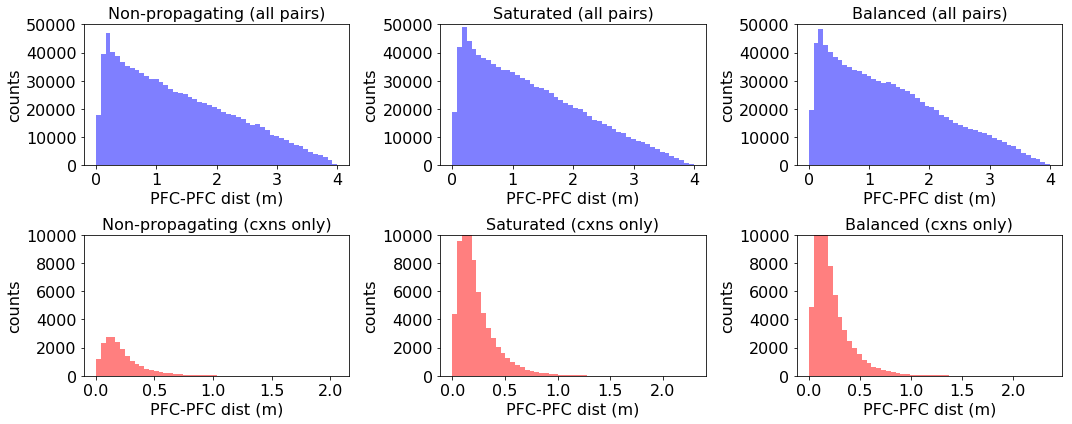

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(15, 6), tight_layout=True)

Y_LIMS = [50000, 10000]

for ntwk, p, title, (ax_0, ax_1) in zip(ntwks, ps, titles, axs.T):
    n_pc = ntwk.n_pc
    
    # get PC-PC dists
    xs = np.tile(ntwk.pfcs[[0], :n_pc], (n_pc, 1))
    ys = np.tile(ntwk.pfcs[[1], :n_pc].T, (1, n_pc))
    ds = np.sqrt((xs - xs.T)**2 + (ys - ys.T)**2)
    
    # get cxn mask
    cxns = ntwk.ws_rcr['AMPA'][:n_pc, :n_pc] > 0
    
    # plot histograms
    ax_0.hist(ds.flatten(), bins=50, color='b', alpha=0.5)
    ax_0.set_ylim(0, Y_LIMS[0])
    ax_0.set_title('{} (all pairs)'.format(title))
    
    ax_1.hist(ds[cxns.todense()], bins=50, color='r', alpha=0.5)
    ax_1.set_ylim(0, Y_LIMS[1])
    ax_1.set_title('{} (cxns only)'.format(title))
    
for ax in axs.flatten():
    ax.set_xlabel('PFC-PFC dist (m)')
    ax.set_ylabel('counts')
    set_font_size(ax, 16)

Test passed if blue hists are all the same but red hist decays apparently exponentially with increasing distance and is smallest in first panel.

##### Test EC-driven bkgd response

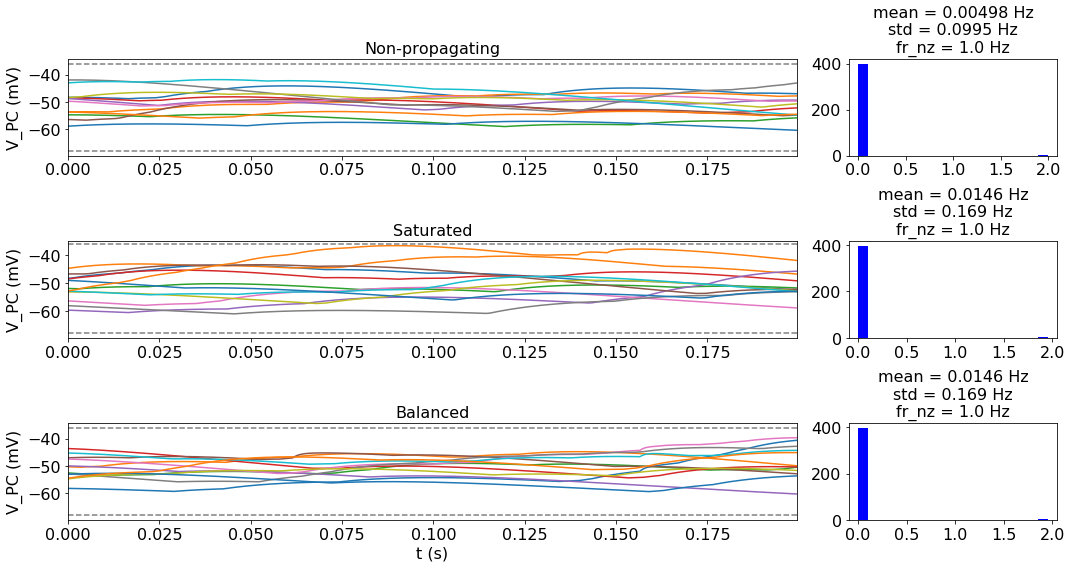

In [10]:
from search.embedded import sample_v_0_g_0_fr_nz

vs_0_all = []
gs_0_all = []
frs_nz = []
rsps_bkgd = []
rates_bkgd = []

gs = gridspec.GridSpec(3, 4)
fig = plt.figure(figsize=(15, 8), tight_layout=True)
axs = [[fig.add_subplot(gs[ctr, :3]), fig.add_subplot(gs[ctr, 3])] for ctr in range(3)]

for ntwk, p, title, axs_ in zip(ntwks, ps, titles, axs):
    
    # compute initial quantities and bkgd response
    vs_0, gs_0, fr_nz, rsp_bkgd, rate_bkgd = sample_v_0_g_0_fr_nz(ntwk, p, pre, C, P, test=True)
    vs_0_all.append(vs_0)
    gs_0_all.append(gs_0)
    frs_nz.append(fr_nz)
    
    # plot voltages for example PCs
    axs_[0].plot(rsp_bkgd.ts, 1000 * rsp_bkgd.vs[:, :12])
    axs_[0].axhline(1000 * P.E_L_PC, color='gray', ls='--')
    axs_[0].axhline(1000 * P.V_TH_PC, color='gray', ls='--')
    
    axs_[0].set_xlim(rsp_bkgd.ts[0], rsp_bkgd.ts[-1])
    axs_[0].set_ylabel('V_PC (mV)')
    axs_[0].set_title(title)
    
    axs_[1].hist(rate_bkgd.flatten(), bins=20, color='b')
    axs_[1].set_title('mean = {0:.3} Hz\nstd = {1:.3} Hz\nfr_nz = {2:.3} Hz'.format(
        rate_bkgd.mean(), rate_bkgd.std(), fr_nz))
    
axs[-1][0].set_xlabel('t (s)')

for ax in sum(axs, []):
    set_font_size(ax, 16)

Test passed if no errors thrown and voltages traces are noisy.

##### Test propagation assessment, angle, activity, and speed

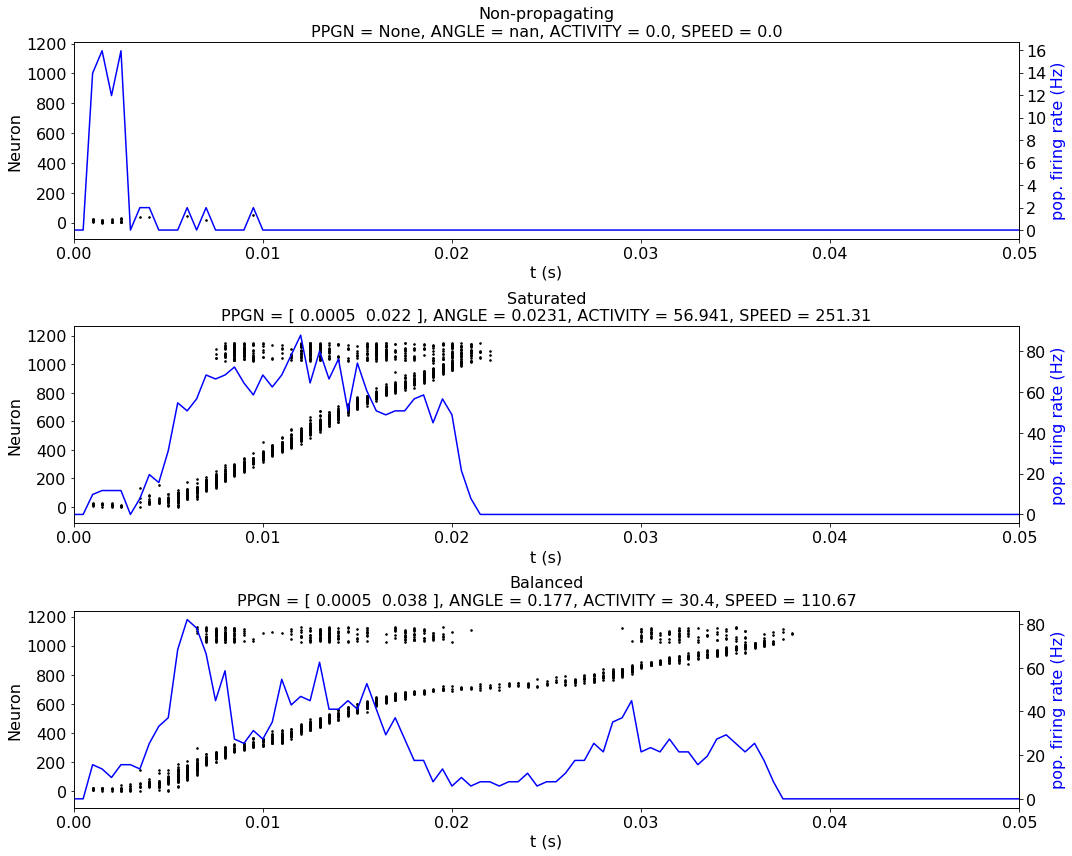

In [11]:
from search.embedded import check_propagation, get_angle, get_activity, get_speed

n_stim = 30
itvl = (0.001, 0.003)
freq = 500
smln_dur = 0.1

rsps = []
ppgns = []
angles = []
activities = []
speeds = []

for ntwk, p, vs_0, gs_0, fr_nz in zip(ntwks, ps, vs_0_all, gs_0_all, frs_nz):
    
    mask = np.argsort(ntwk.pfcs[0, :])[:n_stim]
    
    spks_up = np.random.poisson(p['FR_EC'] * P.DT, (int(smln_dur/P.DT), ntwk.n_ec))
    spks_forced = spks_forced_rand(ntwk, mask, itvl, freq, P.DT)
    
    rsp = ntwk.run(spks_up, P.DT, vs_0, gs_0, spks_forced=spks_forced)
    rsp.pfcs = ntwk.pfcs
    rsp.cell_types = ntwk.cell_types
    
    ppgn = check_propagation(rsp, fr_nz, p, C, P)
    angle = get_angle(rsp, ppgn) if ppgn is not None else np.nan
    activity = get_activity(rsp, ppgn, p, C, P) if ppgn is not None else 0.
    speed = get_speed(rsp, ppgn, p, C) if ppgn is not None else 0.
    
    rsps.append(rsp)
    ppgns.append(ppgn)
    angles.append(angle)
    activities.append(activity)
    speeds.append(speed)
    
fig, axs = plt.subplots(3, 1, figsize=(15, 12), tight_layout=True)

for ntwk, rsp, ppgn, angle, activity, speed, title, ax in zip(
        ntwks, rsps, ppgns, angles, activities, speeds, titles, axs):
    
    raster(ax, rsp.ts, rsp.spks, order=np.argsort(rsp.pfcs[0, :]), marker='.', lw=1)
    
    ax.set_ylim(-ntwk.n/10, 1.1*ntwk.n)
    ax.set_title('{0}\nPPGN = {1}, ANGLE = {2:.3}, ACTIVITY = {3:.5}, SPEED = {4:.5}'.format(
        title, ppgn, angle, activity, speed))
    
    ax_twin = ax.twinx()
    ax_twin.plot(rsp.ts, np.mean(rsp.spks[:, :ntwk.n_pc] / P.DT, axis=1), color='b')
    ax_twin.set_ylabel('pop. firing rate (Hz)', color='b')
    
    ax.set_xlim(0, 0.05)
    
    set_font_size(ax, 16)
    set_font_size(ax_twin, 16)

Tests passed if bottom two rasters show clear propagation (with INH responses in top set of nrns), with propagation window indicated in title, and with the middle row having higher activity level and speed than the bottom row. Speed should also correspond roughly to ridge length (4 m) divided by propagation time.

##### Test stabilization function

Non-propagating:
93 initial forced spks.

Saturated:
106 initial forced spks.
Run 1: 106.0 forced spks, fr_decay = 0.0294 Hz
Run 2: 100.0 forced spks, fr_decay = 0.0297 Hz

Balanced:
93 initial forced spks.
Run 1: 93.0 forced spks, fr_decay = 0.00922 Hz
Run 2: 42.0 forced spks, fr_decay = 0.00886 Hz



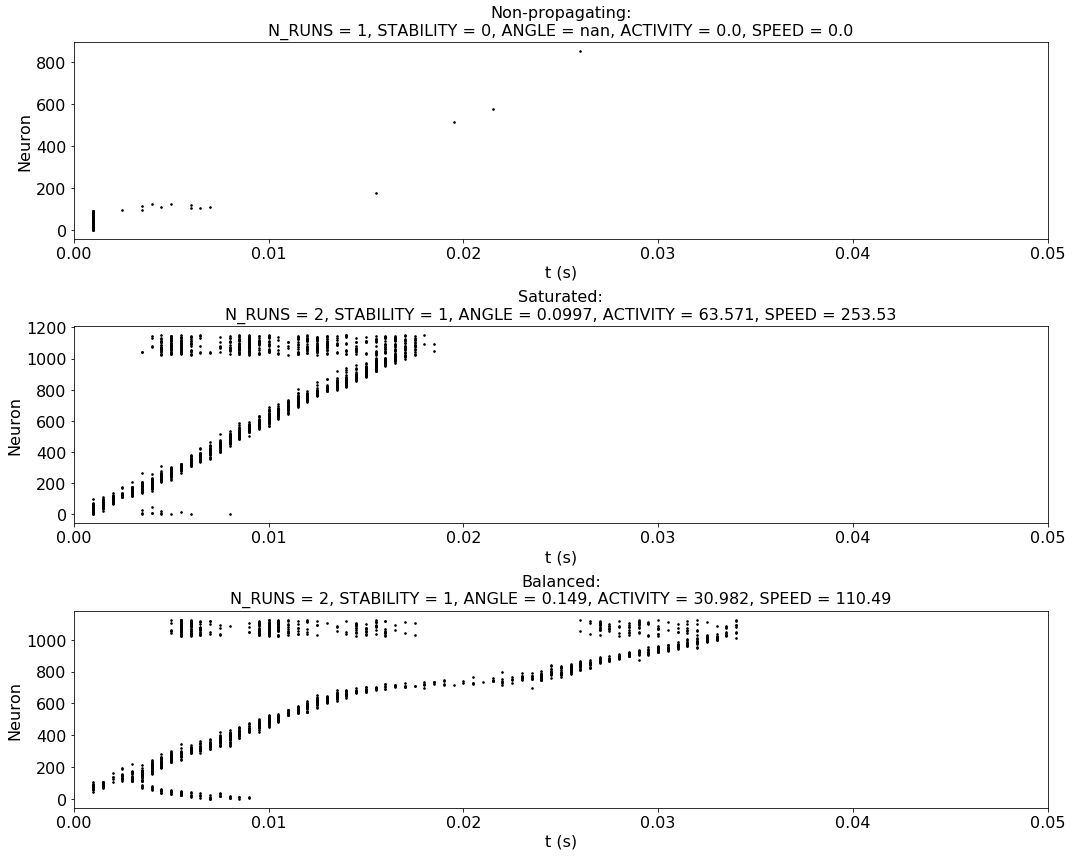

In [12]:
from search.embedded import stabilize

fig, axs = plt.subplots(3, 1, figsize=(15, 12), tight_layout=True)

for ntwk, p, title, ax in zip(ntwks, ps, titles, axs):
    print('{}:'.format(title))
    rsps, stability, angle, activity, speed = stabilize(ntwk, p, pre, C, P, test=True)
    print('')
    
    raster(ax, rsps[-1].ts, rsps[-1].spks, order=np.argsort(ntwk.pfcs[0, :]), marker='.', lw=1)
    ax.set_xlim(0, 0.05)
    ax.set_title(
        '{0}:\nN_RUNS = {1}, STABILITY = {2}, ANGLE = {3:.3}, ACTIVITY = {4:.5}, SPEED = {5:.5}'.format(
        title, len(rsps), stability, angle, activity, speed))
    
    set_font_size(ax, 16)

Test passed if:

* middle and bottom rasters show clear sequential propagation but top does not
* stability is 0 for top panel and 1 for middle and bottom
* n_runs is 1 for top panel, and > 1 for middle and bottom
* angle is nan for top panel, and near 0 for middle and bottom
* activity and speed are higher in middle panel than bottom
* forced spks for each run in saturated and balanced simulations are around ~50-100.

##### Test of full objective function

In [13]:
# define objective function
obj = lambda p, seed: ntwk_obj(p, pre, C, P, seed)

rslts = []

for p, title in zip(ps, titles):
    
    rslts_ = obj(p, 0)
    print('{}: {}'.format(title, rslts_))
    
    rslts.append(rslts_)
    
assert rslts[0]['STABILITY'] == 0
assert np.isnan(rslts[0]['ANGLE'])
assert rslts[0]['ACTIVITY'] == 0
assert rslts[0]['SPEED'] == 0

assert rslts[1]['STABILITY'] == 1
assert rslts[2]['STABILITY'] == 1
assert np.abs(rslts[1]['ANGLE']) < 10
assert np.abs(rslts[2]['ANGLE']) < 10

assert rslts[2]['ACTIVITY'] < rslts[1]['ACTIVITY']
assert rslts[2]['SPEED'] < rslts[1]['SPEED']

print('\nTests passed.')

Non-propagating: {'STABILITY': 0.0, 'ANGLE': nan, 'ACTIVITY': 0.0, 'SPEED': 0.0}
Saturated: {'STABILITY': 1.0, 'ANGLE': 0.095270542354468801, 'ACTIVITY': 62.427746486886271, 'SPEED': 251.54197967359787}
Balanced: {'STABILITY': 1.0, 'ANGLE': 0.073752908751022139, 'ACTIVITY': 35.552469135802475, 'SPEED': 137.18521508714676}

Tests passed.


### Unit tests of auxiliary search functions

In [14]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

from plot import set_font_size

##### Parameter conversions

In [15]:
from search.ridge import make_param_conversions

class Cfg(object):
    
    P_RANGES = [
        ('y', [1, 2, 1]),
        ('z', [1, 2, 3]),
        ('w', [5]),
    ]

cfg = Cfg()

p_to_x, x_to_p = make_param_conversions(cfg)

p = {'y': 1.25, 'z': 1.25, 'w': 7}
x_correct = np.array([-0.25, -0.75, 0])

np.testing.assert_array_almost_equal(p_to_x(p), x_correct)

x = np.array([-0.25, -0.75, 0])
p_correct = {'y': 1.25, 'z': 1.25, 'w': 5}

np.testing.assert_equal(x_to_p(x), p_correct)

print('Tests passed.')

Tests passed.


##### Parsing of "forcing" positions

In [16]:
from search.embedded import force_to_x

class Cfg(object):
    
    P_RANGES = [
        ('a', [-5, 15, 3]),
        ('b', [2]),
        ('c', [20, 40, 1]),
    ]
    
    SGM_RAND = .5

np.random.seed(0)

cfg = Cfg()

# check that forced is parsed correctly from dict
force_dict = {'a': 0, 'b': 2, 'c': 35}
x_correct = np.array([-0.75, 0, 0.25])

np.testing.assert_array_almost_equal(force_to_x(cfg, force_dict), x_correct)

force_dict = {'a': 0, 'b': 3, 'c': 35}
x_correct = np.array([-0.75, 0, 0.25])

np.testing.assert_array_almost_equal(force_to_x(cfg, force_dict), x_correct)

# check that random force yields in-bounds x
xs = np.array([force_to_x(cfg, 'random') for _ in range(1000)])

np.testing.assert_equal(np.any(xs[:, 0] > .5), True)
np.testing.assert_equal(np.any(xs[:, 0] < -.5), True)
np.testing.assert_equal(np.all((xs[:, 0] >= -1.5) * (xs[:, 0] <= 1.5)), True)
np.testing.assert_equal(np.all(xs[:, 1] == 0), True)
np.testing.assert_equal(np.any(xs[:, 2] > .1), True)
np.testing.assert_equal(np.any(xs[:, 2] < -.1), True)
np.testing.assert_equal(np.all((xs[:, 2] >= -.5) * (xs[:, 2] <= .5)), True)

print('Tests passed.')

Tests passed.


##### Out-of-bounds correction

In [17]:
from search.embedded import fix_x_if_out_of_bounds

class Cfg(object):
    
    P_RANGES = [
        ('y', [1, 2, 1]),
        ('z', [10, 20, 3]),
        ('w', [5]),
    ]

cfg = Cfg()

xs_raw = np.array([
    [-.25, 1.2, 0],
    [.75, -.12, 0],
    [.1, -1.7, 0],
    [-.6, 1.8, 0],
    [-.25, 1.2, 1],
    [-.6, 1.8, -4],
])

xs_fixed_correct = np.array([
    [-.25, 1.2, 0],
    [.5, -.12, 0],
    [.1, -1.5, 0],
    [-.5, 1.5, 0],
    [-.25, 1.2, 0],
    [-.5, 1.5, 0],
])

xs_fixed = np.array([fix_x_if_out_of_bounds(cfg, x) for x in xs_raw])

np.testing.assert_array_almost_equal(xs_fixed, xs_fixed_correct)

print('Tests passed.')

Tests passed.


##### Random parameter sampling

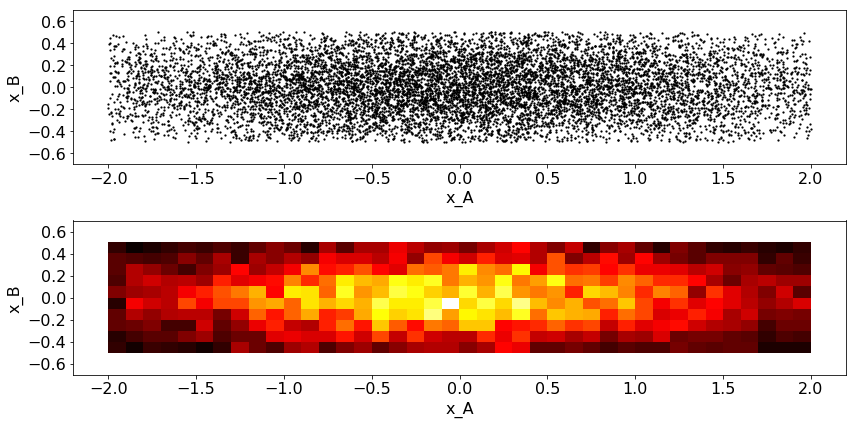

In [18]:
from search.embedded import sample_x_rand

class Cfg(object):
    
    P_RANGES = [
        ('A', [1, 2, 4]),
        ('B', [1, 2, 1]),
    ]
    SGM_RAND = 0.3
    
cfg = Cfg()

xs = np.array([sample_x_rand(cfg) for _ in range(10000)])

fig, axs = plt.subplots(2, 1, figsize=(12, 6), tight_layout=True)

axs[0].scatter(xs[:, 0], xs[:, 1], s=5, c='k', lw=0)
axs[1].hist2d(xs[:, 0], xs[:, 1], bins=(40, 10), cmap='hot')

for ax in axs:
    ax.set_xlim(-2.2, 2.2)
    ax.set_ylim(-.7, .7)
    ax.set_xlabel('x_A')
    ax.set_ylabel('x_B')
    set_font_size(ax, 16)

Test passed if scatter and histogram are confined to rectangle (-2, 2, -.5, .5) and have roughly Gaussian shape, with distribution stretched to match rectangle dimensions.

##### Sampling from previous parameter sets

Here we generate 50 result sets where the activity (k) is very close to k_targ, but the speed (s) is far from s_targ, and 50 result sets where s is very close to s_targ, but k is far from k_targ. If our code works correctly, sampling when activity is valued (B_PREV_K >> B_PREV_S) should yield samples from the first 50 (black hist below), and sampling when speed is valued (B_PREV_S >> B_PREV_K) should yield samples from the second 50 (blue hist below).

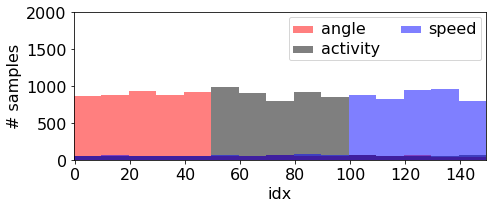

In [19]:
from search.embedded import _sample_x_prev

class Cfg(object):
    
    U_TARG = 0
    K_TARG = 10
    S_TARG = 20
    
    ETA_U = .5,
    ETA_K = .5
    ETA_S = .5
    
    A_PREV = 3
    B_PREV_Y = 0
    B_PREV_U = None
    B_PREV_K = None
    B_PREV_S = None
    
    @property
    def B_PREV_SUM(self): return self.B_PREV_Y + self.B_PREV_U + self.B_PREV_K + self.B_PREV_S
    
# generate result set where half of points are close to K_TARG and half are close to S_TARG
rslts = [
    # samples near U_TARG
    {
        'STABILITY': 1,
        'ANGLE': np.random.normal(0, .05),
        'ACTIVITY': np.random.normal(0, .05),
        'SPEED': np.random.normal(0, 0.05)
    } for _ in range(50)
] + [
    # samples near K_TARG
    {
        'STABILITY': 1,
        'ANGLE': 10 + np.random.normal(0, .05),
        'ACTIVITY': 10 + np.random.normal(0, .05),
        'SPEED': 10 + np.random.normal(0, 0.05)
    } for _ in range(50)
] + [
    # samples near S_TARG
    {
        'STABILITY': 1,
        'ANGLE': 20 + np.random.normal(0, .05),
        'ACTIVITY': 20 + np.random.normal(0, .05),
        'SPEED': 20 + np.random.normal(0, 0.05)
    } for _ in range(50)
]

# corresponding mock parameter set
ps = range(len(rslts))

# build three configs, each heavily weighting either u, k, or s
cfg_u = Cfg()
cfg_u.B_PREV_U = 1
cfg_u.B_PREV_K = 0
cfg_u.B_PREV_S = 0

cfg_k = Cfg()
cfg_k.B_PREV_U = 0
cfg_k.B_PREV_K = 1
cfg_k.B_PREV_S = 0

cfg_s = Cfg()
cfg_s.B_PREV_U = 0
cfg_s.B_PREV_K = 0
cfg_s.B_PREV_S = 1

# take samples
idxs_u = [_sample_x_prev(cfg_u, ps, rslts)[1] for _ in range(5000)]
idxs_k = [_sample_x_prev(cfg_k, ps, rslts)[1] for _ in range(5000)]
idxs_s = [_sample_x_prev(cfg_s, ps, rslts)[1] for _ in range(5000)]

# plot distributions
fig, ax = plt.subplots(1, 1, figsize=(7, 3), tight_layout=True)
ax.hist(idxs_u, bins=np.linspace(-.5, 149.5, 16), color='r', lw=1, alpha=0.5)
ax.hist(idxs_k, bins=np.linspace(-.5, 149.5, 16), color='k', lw=1, alpha=0.5)
ax.hist(idxs_s, bins=np.linspace(-.5, 149.5, 16), color='b', lw=1, alpha=0.5)

ax.legend(['angle', 'activity', 'speed'], ncol=2)
ax.set_xlim(-.5, 149.5)
ax.set_ylim(0, 2000)
ax.set_xlabel('idx')
ax.set_ylabel('# samples')

set_font_size(ax, 16)

Test passed if red hist is uniform and left of 50 (angle-weighted samples), gray hist is uniform and between 50 & 100 (activity-weighted samples), blue hist is uniform and right of 100 (speed-weighted samples), and if there is small dark blue strip on bottom (overlap from random sampling).

##### Generating logical search steps

To test this we generate 8 previous xs, distributed on the corners of the unit cube. We then ensure that the derived optimal directions (phi_mean) end up in the correct octants when different result sets and config files are used.

In [20]:
from search.embedded import compute_phi_mean

class Cfg():
    
    L_PHI = 5
    
    U_TARG = 0
    K_TARG = 10
    S_TARG = 20
    
    ETA_U = .5
    ETA_K = .5
    ETA_S = .5
    
    A_PHI = 3
    B_PHI_Y = 0
    B_PHI_U = None
    B_PHI_K = None
    B_PHI_S = None
    
    @property
    def B_PHI_SUM(self): return self.B_PHI_Y + self.B_PHI_U + self.B_PHI_K + self.B_PHI_S

xs = np.array([[1, 1], [-1, 1], [-1, -1], [1, -1]])

# activity-accurate on top, speed-accurate on bottom
rslts = [
    {'STABILITY': 1, 'ANGLE': 10.1, 'ACTIVITY': 9.5, 'SPEED': 9.9},    # acc. activity
    {'STABILITY': 1, 'ANGLE': 11.2, 'ACTIVITY': 10.1, 'SPEED': 10.2},  # more acc. activity
    {'STABILITY': 1, 'ANGLE': -1.3, 'ACTIVITY': 20.1, 'SPEED': 19.1},  # acc. speed
    {'STABILITY': 1, 'ANGLE': 20.1, 'ACTIVITY': 19.9, 'SPEED': 20.2},  # more acc. speed
]

# cfg weighting activity-accuracy
cfg_u = Cfg()
cfg_u.B_PHI_U = 10
cfg_u.B_PHI_K = 0
cfg_u.B_PHI_S = 0

phi_mean = compute_phi_mean(cfg_u, xs, rslts)
sgns = np.sign(phi_mean)
sgns_correct = np.array([-1, -1])

np.testing.assert_almost_equal(Cfg.L_PHI, np.linalg.norm(phi_mean))
np.testing.assert_array_equal(sgns, sgns_correct)

# cfg weighting activity-accuracy
cfg_k = Cfg()
cfg_k.B_PHI_U = 0
cfg_k.B_PHI_K = 10
cfg_k.B_PHI_S = 0

phi_mean = compute_phi_mean(cfg_k, xs, rslts)
sgns = np.sign(phi_mean)
sgns_correct = np.array([-1, 1])

np.testing.assert_almost_equal(Cfg.L_PHI, np.linalg.norm(phi_mean))
np.testing.assert_array_equal(sgns, sgns_correct)

# cfg weighting speed-accuracy
cfg_s = Cfg()
cfg_s.B_PHI_U = 0
cfg_s.B_PHI_K = 0
cfg_s.B_PHI_S = 10

phi_mean = compute_phi_mean(cfg_s, xs, rslts)
sgns = np.sign(phi_mean)
sgns_correct = np.array([1, -1])

np.testing.assert_almost_equal(Cfg.L_PHI, np.linalg.norm(phi_mean))
np.testing.assert_array_equal(sgns, sgns_correct)

# test that phi_mean is directly down when bottom two xs have equal speeds
rslts = [
    {'STABILITY': 1, 'ANGLE': 1.2, 'ACTIVITY': 9.5, 'SPEED': 9.9},
    {'STABILITY': 1, 'ANGLE': 1.4, 'ACTIVITY': 10.1, 'SPEED': 10.2},
    {'STABILITY': 1, 'ANGLE': 1.3, 'ACTIVITY': 10.2, 'SPEED': 19.1},
    {'STABILITY': 1, 'ANGLE': 1.1, 'ACTIVITY': 10.1, 'SPEED': 19.1},
]

phi_mean = compute_phi_mean(cfg_s, xs, rslts)
np.testing.assert_almost_equal(phi_mean[0], 0)
np.testing.assert_almost_equal(phi_mean[1], -Cfg.L_PHI)

print('Tests completed successfully.')

Tests completed successfully.


### Semi-automated integration tests with mock objective function

In [21]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from db import make_session, d_models
from plot import set_font_size
from search import embedded

import PARAMETERS as P
from search import embedded_global as C


np.random.seed(0)

def mock(p, seed):
    """Mock objective function."""
    y = p['RHO_PC']
    u = p['P_INH']
    k = p['Z_PC']
    s = p['L_PC']
    
    return {'STABILITY': y, 'ANGLE': u, 'ACTIVITY': k, 'SPEED': s}

##### Random search

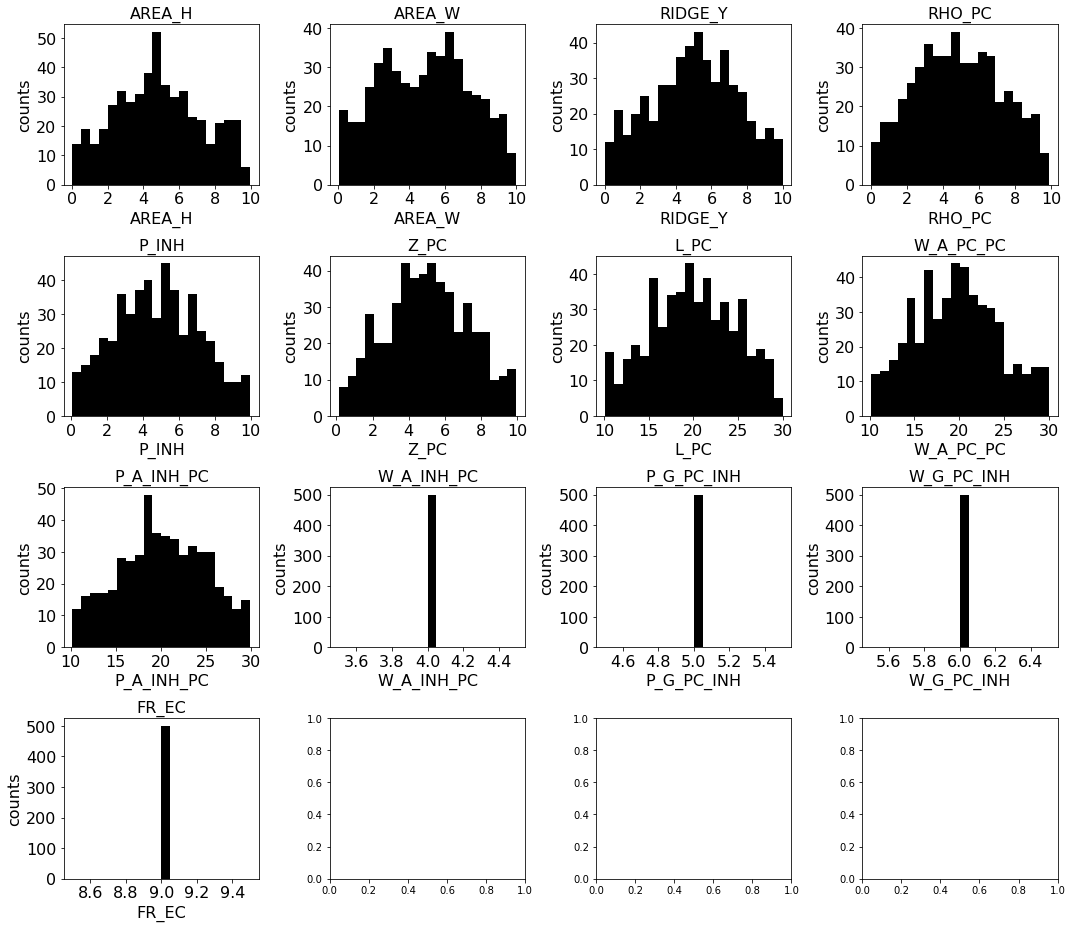

In [22]:
from search.config.embedded import test_random as cfg
C.MAX_SEARCH_ITER = 500

# perform search
searcher_id = embedded.search('test_random', mock, C, seed=0, commit='test_random')

# retrieve search results from db
session = make_session()
trials = session.query(d_models.EmbeddedTrial).filter(
    d_models.EmbeddedTrial.searcher_id == searcher_id).order_by(
    d_models.EmbeddedTrial.id).all()
session.close()

# make sure N_TRIALS trials were added
np.testing.assert_equal(len(trials), C.MAX_SEARCH_ITER)

# make sure first trial has centered params
for name, p_range in cfg.P_RANGES:
    if len(p_range) == 3:
        correct = 0.5 * (p_range[0] + p_range[1])
    else:
        correct = p_range[0]
        
    np.testing.assert_equal(getattr(trials[0], name.lower()), correct)

# make param histograms, which should all be normally distributed
names = [name for name, p_range in cfg.P_RANGES]

fig, axs = plt.subplots(4, 4, figsize=(15, 13), tight_layout=True)

for name, ax in zip(names, axs.flatten()):
    
    data = [getattr(trial, name.lower()) for trial in trials]
    ax.hist(data, bins=20, color='k')
    
    ax.set_xlabel(name)
    ax.set_ylabel('counts')
    ax.set_title(name)
    
    set_font_size(ax, 16)

Test passed if first 6 histograms are approximately gaussian, truncated at 0 and 10, next 3 are approx. gaussian  truncated at 10 and 30, and final 4 are delta functions centered at 4, 5, 6, and 9 respectively.

##### Guided search

Here we use a config file specifying an optimal solution when P_INH = Z_PC = L_PC = 9, with the other params irrelevant. We ensure its correct functioning by plotting out the sequence of P_INH, Z_PCm and L_PC arrived at by the search process, to ensure they move in the direction of the optimum. We perform the search with two different average step sizes.

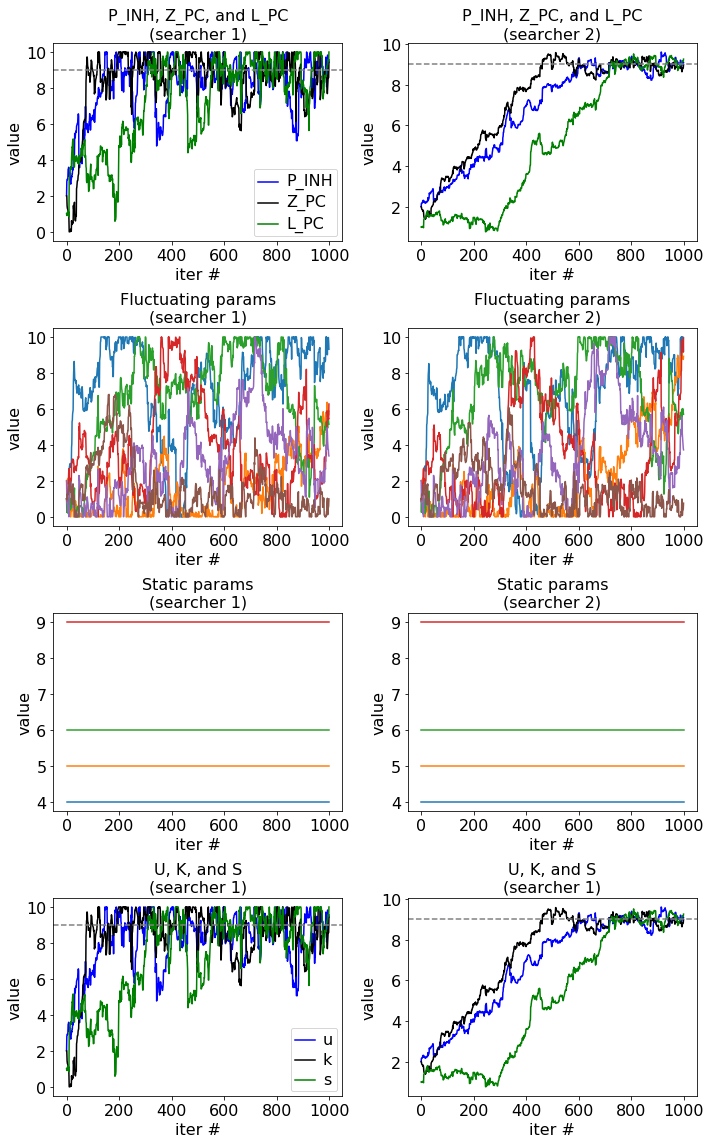

In [23]:
from search.config.embedded import test_guided_1 as cfg_1
from search.config.embedded import test_guided_2 as cfg_2

C.MAX_SEARCH_ITER = 1000

# perform search for both searchers
searcher_id_1 = embedded.search('test_guided_1', mock, C, seed=0, commit='test_guided')

searcher_id_2 = embedded.search('test_guided_2', mock, C, seed=0, commit='test_guided')

# retrieve search results from db
session = make_session()
trials_1 = session.query(d_models.EmbeddedTrial).filter(
    d_models.EmbeddedTrial.searcher_id == searcher_id_1).order_by(
    d_models.EmbeddedTrial.id).all()
trials_2 = session.query(d_models.EmbeddedTrial).filter(
    d_models.EmbeddedTrial.searcher_id == searcher_id_2).order_by(
    d_models.EmbeddedTrial.id).all()
session.close()

# make sure N_TRIALS trials were added
np.testing.assert_equal(len(trials_1), C.MAX_SEARCH_ITER)
np.testing.assert_equal(len(trials_2), C.MAX_SEARCH_ITER)

# get p_inh, z_pc, and l_pc
p_inhs_1 = [trial.p_inh for trial in trials_1]
z_pcs_1 = [trial.z_pc for trial in trials_1]
l_pcs_1 = [trial.l_pc for trial in trials_1]
p_inhs_2 = [trial.p_inh for trial in trials_2]
z_pcs_2 = [trial.z_pc for trial in trials_2]
l_pcs_2 = [trial.l_pc for trial in trials_2]

# get propagations, activities, and speeds for each searcher
ys_1 = [trial.stability for trial in trials_1]
us_1 = [trial.angle for trial in trials_1]
ks_1 = [trial.activity for trial in trials_1]
ss_1 = [trial.speed for trial in trials_1]

ys_2 = [trial.stability for trial in trials_2]
us_2 = [trial.angle for trial in trials_2]
ks_2 = [trial.activity for trial in trials_2]
ss_2 = [trial.speed for trial in trials_2]

# get fluctuating or static irrelevant params
fluc_1 = []
static_1 = []
for trial in trials_1:
    
    fluc_ = [
        trial.area_h, trial.area_w, trial.ridge_y, trial.rho_pc,
        trial.w_a_pc_pc, trial.p_a_inh_pc, 
    ]
    
    fluc_1.append(fluc_)
    
    static_ = [
        trial.w_a_inh_pc,
        trial.p_g_pc_inh, trial.w_g_pc_inh,
        trial.fr_ec,
    ]
    
    static_1.append(static_)

fluc_1 = np.array(fluc_1)
static_1 = np.array(static_1)

fluc_2 = []
static_2 = []
for trial in trials_2:
    
    fluc_ = [
        trial.area_h, trial.area_w, trial.ridge_y, trial.rho_pc,
        trial.w_a_pc_pc, trial.p_a_inh_pc, 
    ]
    
    fluc_2.append(fluc_)
    
    static_ = [
        trial.w_a_inh_pc,
        trial.p_g_pc_inh, trial.w_g_pc_inh,
        trial.fr_ec,
    ]
    
    static_2.append(static_)

fluc_2 = np.array(fluc_2)
static_2 = np.array(static_2)

# plot parameter trajectories
fig, axs = plt.subplots(4, 2, figsize=(10, 16), tight_layout=True)

# plot p_inh, z_pc, and l_pc for searchers 1 and 2
axs[0, 0].plot(p_inhs_1, color='b')
axs[0, 0].plot(z_pcs_1, color='k')
axs[0, 0].plot(l_pcs_1, color='g')
axs[0, 0].legend(['P_INH', 'Z_PC', 'L_PC'])
axs[0, 0].axhline(cfg_1.U_TARG, color='gray', ls='--')
axs[0, 0].set_title('P_INH, Z_PC, and L_PC\n(searcher 1)')

axs[0, 1].plot(p_inhs_2, color='b')
axs[0, 1].plot(z_pcs_2, color='k')
axs[0, 1].plot(l_pcs_2, color='g')
axs[0, 1].axhline(cfg_2.U_TARG, color='gray', ls='--')
axs[0, 1].set_title('P_INH, Z_PC, and L_PC\n(searcher 2)')

# plot fluctuating params for both searchers
axs[1, 0].plot(fluc_1)
axs[1, 0].set_title('Fluctuating params\n(searcher 1)')

axs[1, 1].plot(fluc_2)
axs[1, 1].set_title('Fluctuating params\n(searcher 2)')

# plot static params for both searchers
axs[2, 0].plot(static_1)
axs[2, 0].set_title('Static params\n(searcher 1)')

axs[2, 1].plot(static_2)
axs[2, 1].set_title('Static params\n(searcher 2)')

# plot results for each searcher
axs[3, 0].plot(us_1, color='b')
axs[3, 0].plot(ks_1, color='k')
axs[3, 0].plot(ss_1, color='g')
axs[3, 0].legend(['u', 'k', 's'])
axs[3, 0].axhline(cfg_1.U_TARG, color='gray', ls='--')
axs[3, 0].set_title('U, K, and S\n(searcher 1)')

axs[3, 1].plot(us_2, color='b')
axs[3, 1].plot(ks_2, color='k')
axs[3, 1].plot(ss_2, color='g')
axs[3, 1].axhline(cfg_2.U_TARG, color='gray', ls='--')
axs[3, 1].set_title('U, K, and S\n(searcher 1)')

for ax in axs.flatten():
    
    ax.set_xlabel('iter #')
    ax.set_ylabel('value')
    
    set_font_size(ax, 16)

Test passed if both P_INH, Z_PC, and L_PC (blue, black, and green, top panels) approach then hover around their target values (indicated by the gray dashed line), with right panel less noisy, if the second row of panels appears to be basically random, if the third row of panels is flat, and if the bottom row matches the top, except for the labels. Finally, right top panel should approach slower than left top panel (due to increased search resolution on right panel).

##### Blend of guided and jumping to random points

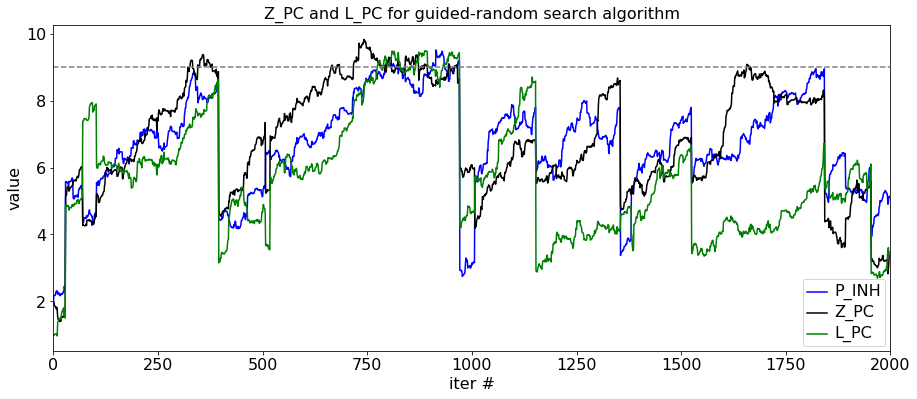

In [24]:
from search.config.embedded import test_blend_rand as cfg

C.MAX_SEARCH_ITER = 2000

# perform search
searcher_id = embedded.search('test_blend_rand', mock, C, seed=0, commit='test_blend')

# get trials and params
session = make_session()
trials = session.query(d_models.EmbeddedTrial).filter(
    d_models.EmbeddedTrial.searcher_id == searcher_id).order_by(
    d_models.EmbeddedTrial.id).all()
session.close()

# make sure N_TRIALS trials were added
np.testing.assert_equal(len(trials), C.MAX_SEARCH_ITER)

# get p_inh, z_pc, and l_pc
p_inhs = [trial.p_inh for trial in trials]
z_pcs = [trial.z_pc for trial in trials]
l_pcs = [trial.l_pc for trial in trials]

# plot trajectory of z_pc and l_pc
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

ax.plot(p_inhs, color='b')
ax.plot(z_pcs, color='k')
ax.plot(l_pcs, color='g')

ax.legend(['P_INH', 'Z_PC', 'L_PC'])
ax.axhline(cfg.U_TARG, color='gray', ls='--')

ax.set_xlim(0, C.MAX_SEARCH_ITER)

ax.set_xlabel('iter #')
ax.set_ylabel('value')
ax.set_title('Z_PC and L_PC for guided-random search algorithm')

set_font_size(ax, 16)

Test passed if P_INH, Z_PC, and L_PC exhibit trajectories more or less moving towards y = 9, except that every once in a while they are randomly translated to a new location.

##### Blend of guided and jumping to previous points

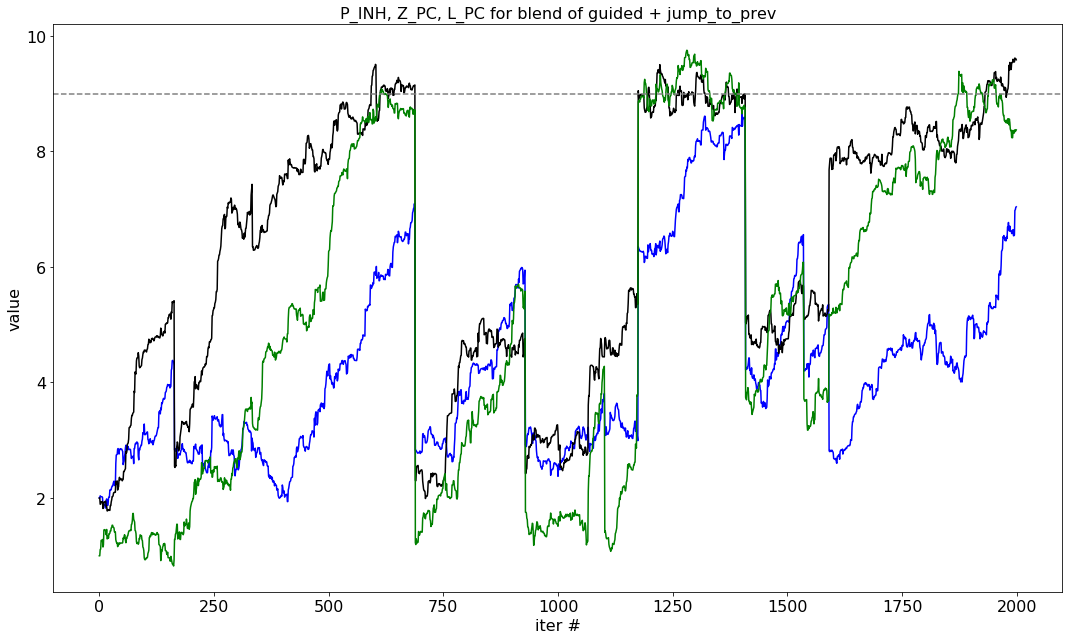

In [25]:
from search.config.embedded import test_blend_prev as cfg

# delete all trials with this smln id
session = make_session()

# first get all searcher ids with this smln id
searchers_old = session.query(d_models.EmbeddedSearcher.id).filter(
    d_models.EmbeddedSearcher.smln_id == cfg.SMLN_ID)
searcher_ids_old = [s.id for s in searchers_old]

# delete all trials corresponding to these searchers
if searcher_ids_old:
    trials_old = session.query(d_models.EmbeddedTrial).filter(
        d_models.EmbeddedTrial.searcher_id.in_(searcher_ids_old))
    trials_old.delete(synchronize_session='fetch')
    
    session.commit()

trials_old = session.query(d_models.EmbeddedTrial.id).join(
    d_models.EmbeddedSearcher).filter(
    d_models.EmbeddedSearcher.smln_id == cfg.SMLN_ID)

np.testing.assert_equal(trials_old.count(), 0)
    
session.close()

C.MAX_SEARCH_ITER = 2000

# perform search
searcher_id = embedded.search('test_blend_prev', mock, C, seed=1, commit='test_blend')

# get trials and params
session = make_session()
trials = session.query(d_models.EmbeddedTrial).filter(
    d_models.EmbeddedTrial.searcher_id == searcher_id).order_by(
    d_models.EmbeddedTrial.id).all()

# make sure only N_TRIALS trials exist for this simulation
trials_ = session.query(d_models.EmbeddedTrial).join(
    d_models.EmbeddedSearcher).filter(
    d_models.EmbeddedSearcher.smln_id == cfg.SMLN_ID)
np.testing.assert_equal(trials_.count(), C.MAX_SEARCH_ITER)

session.close()

# make sure N_TRIALS trials were added
np.testing.assert_equal(len(trials), C.MAX_SEARCH_ITER)

# get p_inh, z_pc, and l_pc
p_inhs = [trial.p_inh for trial in trials]
z_pcs = [trial.z_pc for trial in trials]
l_pcs = [trial.l_pc for trial in trials]

# plot trajectory of z_pc and l_pc
fig, ax = plt.subplots(1, 1, figsize=(15, 9), tight_layout=True)

ax.plot(p_inhs, color='b')
ax.plot(z_pcs, color='k')
ax.plot(l_pcs, color='g')

ax.axhline(cfg.U_TARG, color='gray', ls='--')

ax.set_xlabel('iter #')
ax.set_ylabel('value')

ax.set_title('P_INH, Z_PC, L_PC for blend of guided + jump_to_prev')

set_font_size(ax, 16)

Test passed if p_inh (blue), z_pc (black), and green (l_pc) appear to be moving towards dashed gray line, but occasionally get randomly reset to what appear to previous (p_inh, z_pc, l_pc) triplets.

### Manual integration tests

In [26]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

from db import make_session, d_models
from plot import set_font_size
from search import embedded

import PARAMETERS as P
from search import embedded_global as C


np.random.seed(0)

def mock(p, seed):
    """Mock objective function."""
    y = p['RHO_PC']
    u = p['P_INH']
    k = p['Z_PC']
    s = p['L_PC']
    
    time.sleep(1)
    
    return {'STABILITY': y, 'ANGLE': u, 'ACTIVITY': k, 'SPEED': s}

##### Response to forcing sequences

To run this test, first make sure that the FORCE attribute is commented out in search/config/ridge/test_forced.py . Then execute the code below. It will print the current searcher id and then begin the search process. After counting to about 10, replace the key -1 in forcing.py with the printed searcher ID, uncomment it, and save, then let the search continue running. When test is complete, change forcing.py back to its original state (easiest way is to use "git checkout -- forcing.py"). The whole test should take about 20 s.

SEARCHER ID = 49
New forcing sequence detected.


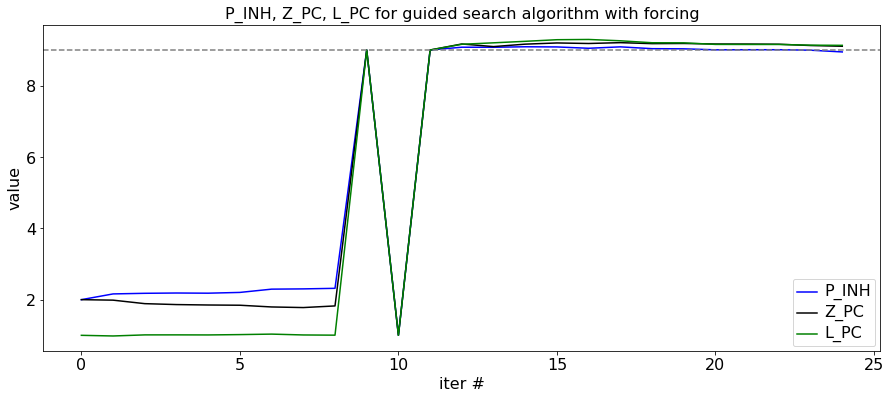

In [27]:
from search.config.embedded import test_forced as cfg

C.MAX_SEARCH_ITER = 25

# perform search
searcher_id = embedded.search('test_forced', mock, C, seed=0, commit='test_forced', verbose=True)

# get trials and params
session = make_session()
trials = session.query(d_models.EmbeddedTrial).filter(
    d_models.EmbeddedTrial.searcher_id == searcher_id).order_by(
    d_models.EmbeddedTrial.id).all()
session.close()

# make sure N_TRIALS trials were added
np.testing.assert_equal(len(trials), C.MAX_SEARCH_ITER)

# get p_inh, z_pc, and l_pc
p_inhs = [trial.p_inh for trial in trials]
z_pcs = [trial.z_pc for trial in trials]
l_pcs = [trial.l_pc for trial in trials]

# plot trajectory of z_pc and l_pc
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

ax.plot(p_inhs, color='b')
ax.plot(z_pcs, color='k')
ax.plot(l_pcs, color='g')

ax.legend(['P_INH', 'Z_PC', 'L_PC'])
ax.axhline(cfg.U_TARG, color='gray', ls='--')

ax.set_xlabel('iter #')
ax.set_ylabel('value')
ax.set_title('P_INH, Z_PC, L_PC for guided search algorithm with forcing')

set_font_size(ax, 16)

Test passed  if "New forcing sequence detected" is output, and if sharp [9, 1, 9] inverted spike is seen around iteration 10.

##### Response to configuration errors

To run this test execute the code below, then after about 10s, modify search/config/embedded/test_forced.py to make it invalid (e.g. change one of the param names in P_RANGES). Next, open up sandbox.ipynb and run the following code:

```
from search.embedded import search_status, read_search_error

search_status(smln_id='test_forced')
```

and look up the error message using the printed searcher ID:

```
read_search_error(<PRINTED SEARCHER ID>)
```

to ensure it matches the one printed to the screen.

Next, correct the error, wait about 5 seconds and rerun `read_search_error`, which should note that no error has been detected.

SEARCHER ID = 50
Configuration error detected.
Traceback (most recent call last):
  File "/Users/rkp/Dropbox/Repositories/replay/search/embedded.py", line 107, in search
    validate(cfg, ctr)
  File "/Users/rkp/Dropbox/Repositories/replay/search/embedded.py", line 978, in validate
    'Force "{}" missing keys: {}'.format(key, missing))
Exception: Force "START" missing keys: ['AREA_H']



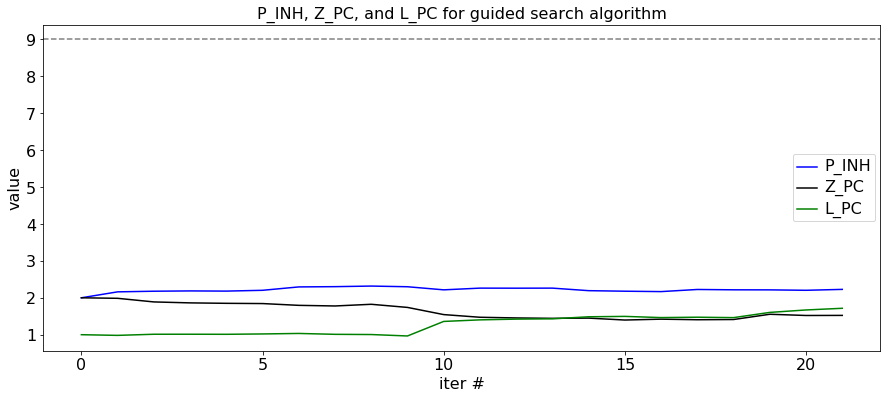

In [28]:
from search.config.embedded import test_forced as cfg

C.MAX_SEARCH_ITER = 25

# perform search
searcher_id = embedded.search('test_forced', mock, C, seed=0, commit='test_forced', verbose=True)

# get trials and params
session = make_session()
trials = session.query(d_models.EmbeddedTrial).filter(
    d_models.EmbeddedTrial.searcher_id == searcher_id).order_by(
    d_models.EmbeddedTrial.id).all()
session.close()

# get p_inh, z_pc, and l_pc
p_inhs = [trial.p_inh for trial in trials]
z_pcs = [trial.z_pc for trial in trials]
l_pcs = [trial.l_pc for trial in trials]

# plot trajectory of z_pc and l_pc
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

ax.plot(p_inhs, color='b')
ax.plot(z_pcs, color='k')
ax.plot(l_pcs, color='g')

ax.legend(['P_INH', 'Z_PC', 'L_PC'])
ax.axhline(cfg.U_TARG, color='gray', ls='--')

ax.set_xlabel('iter #')
ax.set_ylabel('value')
ax.set_title('P_INH, Z_PC, and L_PC for guided search algorithm')

set_font_size(ax, 16)

Test passed if plot with inoffensive blue, black, and green lines is displayed and cell output indicates configuration error and shows traceback.